NOMBRE: Alan

APELLIDOS: García Justel

# Ejemplo del satélite artificial: Aplicación del método Eurler Mejorado

<ul id="top">
<li><a href="#Definiciones">Definiciones</a></li>
<li><a href="#1-Método-de-Euler-Mejorado">1-Método de Euler Mejorado</a></li>
      <ul>
        <li><a href="#Implementación-del-método-Euler-Mejorado">Implementación del método Euler Mejorado</a></li>
        <li><a href="#Comprobación-de-la-implementación-en-el-problema-de-dos-cuerpos-en-el-plano">Comprobación de la implementación en el problema de dos cuerpos en el plano</a></li>
        <li><a href="#Estudio-de-la-eficiencia-de-la-implementación">Estudio de la eficiencia de la implementación</a></li>
      </ul>
<li><a href="#2-Satélite-artificial-orbitando-alrededor-de-la-tierra">2-Satélite artificial orbitando alrededor de la tierra</a></li>  
      <ul>   
<li><a href="#Modelo-simplificado">Modelo simplificado</a></li>
<li><a href="#Modelo-más-realista">Modelo más realista</a></li>
          </ul>
</ul>  

## Definiciones

In [1]:
using LinearAlgebra
using Plots

Queremos simular numéricamente la evolución de sistemas modelados por 
ecuaciones diferenciales ordinarias (EDOs) de dimensión $d\geq 1$ de la forma

<a id='Edo-Compacta'></a>
\begin{equation*}
\frac{d}{dt} u = f(t,u,p). \hspace{10em} \tag{1}
\end{equation*}

donde $u =(u^1,\ldots,u^d) \in \mathbb{R}^d$ es el _vector de estado_ del sistema, y $p \in \mathbb{R}^m$ es un vector de parámetros constantes del sistema.

Sabemos que, fijado el vector $p$ de parámetros constantes, 
dados $t_0 \in \mathbb{R}$ y $u_0 =(u^1_0,\ldots,u^d_0) \in \mathbb{R}^d$, existe una única solución $u(t)$ de [(1)](#Edo-Compacta) que satisfaga la condición inicial

<a id='Cond-Ini'></a>
\begin{equation*}
  u(t_0)=u_0. \hspace{12em} \tag{2}
\end{equation*}

En la práctica, nos interesará calcular de forma aproximada la solución $u(t)$ para un cierto intervalo temporal $t \in [t_0,T]$. 

El tipo compuesto de datos ProblemaEDO contiene información sobre el problema de valores iniciales a resolver:

In [2]:
struct ProblemaEDO
    f::Function
    u0::Vector{Float64}
    tspan::Tuple{Float64,Float64}
    p::Vector{Float64}
end


El campo f en ProblemaEDO es el nombre de una función, tal que dados $t \in \mathbb{R}$, un vector $u \in \mathbb{R}^d$, y un vector de parámetros $p\in \mathbb{R}^m$,
devuelve un vector $f(t,u,p) \in \mathbb{R}^d$. Dicha función determina un sistema de EDOs de la forma [(1)](#Edo-Compacta).


Se aproximará la solución $u(t)$ de (1)--(2) en una discretización del tiempo obtenida de dividir el intervalo temporal $[t_0,T]$ en $n$ partes iguales. Es decir,  se tomará los valores discretos del tiempo $t_0,t_1,t_2,\ldots,t_{n-1},t_n=T$, donde $t_k=t_{0}+k h$, con $h=(T-t_0)/n$, y se calcularán las aproximaciones 
$u_k =(u^1_k,\ldots,u^d_k) \approx u(t_k)$ para $k=0,1,\ldots,n$.

En el tipo compuesto SolucionProblemaEDO definido a continuación,  

- en **t** se guarda el vector de tiempos $t_0,t_1,t_2,\ldots,t_n$,
- en **u** se guardan las aproximaciones $u_k \approx u(t_k)$ ($k=0,1,2,\ldots,n$),
- en **prob**, el problema original cuya solución se guarda en SolucionProblemaEDO

In [3]:
struct SolucionProblemaEDO
    t::Vector{Float64}
    u::Vector{Vector{Float64}}
    prob::ProblemaEDO
end

<a href="#top">Volver al inicio</a>

## 1-Método de Euler Mejorado


- El método de Euler mejorado basado en la regla del trapecio se define de la siguiente manera:

Para $j=0,1,2,\dots$

\begin{align*}
&t_{j+1}=t_j+h, \quad u_{j+1}=u_j+ \frac{h}{2}\, \left(f(t_j, u_{j}) +  f(t_j+h, \ \tilde u_{j+1}) \right)\\
&\text{donde} \qquad 
\tilde u_{j+1}=u_j+h\, f(t_j,u_j).  \hspace{8.cm}   
\end{align*}


### Implementación del método Euler Mejorado

#### 1.1-Ejercicio

Para realizar los ejercicios de simulación que siguen, se debe primeramente implementar el método Euler Mejorado en Julia. Se definirá una función (que llamaremos EulerMejorado) con los mismos argumentos de entrada y salida que la función Euler implementada en el documento Euler.ipynb disponible en el aula virtual.


In [5]:
function  EulerMejorado(problema::ProblemaEDO,n::Int64,m::Integer=1)  
    # n: número de soluciones/vectores de estado a calcular
    # m: cada cuántos steps se guarda un vector de estado para el cálculo final
    # En funcion de n y m se calcula h -> 
    #      h: Intervalo de tiempo entre cada una de las soluciones guardadas (si m = 1).
    #         Si no, el intervalo de tiempo entre cada una de las soluciones es h * m
    
    u0   = problema.u0    # Vector de la solución inicial
    t0,T = problema.tspan # Intervalo de tiempo para calcular la solución aproximada
    p    = problema.p     # Vector de parámetros constantes
    f    = problema.f     # Función de modelado del problema | Ecuación diferencial a resolver (en formato vectorial)
    
    h = (T-t0)/(n*m) # Intervalo de tiempo entre cada una de las soluciones
    tt = [t0]        # Vector de tiempos
    uu = [u0]        # Vector de estados
    
    tj = t0 # Inicializar el instante inicial
    uj = u0 # Inicializar el vector de estado inicial
    for j in 1:n
        # Para cada solución que queremos guardar
        for i in 1:m    
            # Avanzamos m steps en el método de Euler Mejorado
             uj = EulerMStep(tj,uj,h,f,p)
             tj += h
        end
        # Guardamos t y u
        push!(tt,tj)
        push!(uu,uj)
    end
    
    return SolucionProblemaEDO(tt,uu,problema)
  end

function EulerMStep(tj,uj,h,f,p)
    # Función para obtener el siguiente vector de estado u_j+1
    #    u_j+1 = u_j + h/2 * ( f(t_j, u_j) + f[t_j + h, u_j + h * f(t_j, u_j)] ) ->
    # -> u_j+1 = u_j + h/2 * ( du + f[t_j + h, u_j + h * du ] ) ->
    # -> u_j+1 = u_j + h/2 * ( du + f[t_, u_] )
    #    luego:
    #    du  = f(tj, uj, p)
    #    u_  = uj + h * du
    #    t_  = tj + h
    #    du_ = f(t_, u_, p)
    #    uj+1 = uj + h/2 * (du + du_)
    #
    
    du  = f(tj, uj, p)
    u_  = uj + h * du
    t_  = tj + h
    du_ = f(t_, u_, p)
    return uj + h/2 * (du + du_)
end
 

EulerMStep (generic function with 1 method)

Compararemos los resultados del método de Euler mejorado con los del método de Euler, implementado con anterioridad.

In [6]:
function  Euler(problema::ProblemaEDO,n,m=1)
    # n: número de soluciones/vectores de estado a calcular
    # m: cada cuántos steps se guarda un vector de estado para el cálculo final
    # En funcion de n y m se calcula h -> 
    #      h: Intervalo de tiempo entre cada una de las soluciones guardadas (si m = 1).
    #         Si no, el intervalo de tiempo entre cada una de las soluciones es h * m
    
    u0   = problema.u0    # Vector de la solución inicial
    t0,T = problema.tspan # Intervalo de tiempo para calcular la solución aproximada
    p    = problema.p     # Vector de parámetros constantes
    f    = problema.f     # Función de modelado del problema | Ecuación diferencial a resolver (en formato vectorial)
    
    h = (T-t0)/(n*m) # Intervalo de tiempo entre cada una de las soluciones
    tt = [t0]        # Vector de tiempos
    uu = [u0]        # Vector de estados
    
    tj = t0 # Inicializar el instante inicial
    uj = u0 # Inicializar el vector de estado inicial
    
    for j in 1:n
        # Para cada solución que queremos guardar
        for i in 1:m
            # Avanzamos m steps en el método de Euler
             uj += h * f(tj, uj, p)
             tj += h
        end
        # Guardamos t y u
        push!(tt,tj)
        push!(uu,uj)
    end
    return SolucionProblemaEDO(tt,uu,problema)
  end

Euler (generic function with 2 methods)

<a href="#top">Volver al inicio</a>

### Comprobación de la implementación en el problema de dos cuerpos en el plano

El problema de dos cuerpos en el plano describe muy bien los principales aspectos del movimiento de los satélites.
Para calcular el movimiento de dos cuerpos que se atraen mutuamente, elegimos uno de los cuerpos como el centro de nuestro sistema de coordenadas; el movimiento del segundo cuerpo se realiza en el plano y su posición viene dada por las coordenadas $q=(q_1,q_2)$. La ley de Newton, con una normalización adecuada, da como resultado la siguiente ecuación diferencial,
 


\begin{align*}
& \frac{d}{dt} q_x= v_x, \quad  \frac{d}{dt} q_y= v_y \\
&\frac{d}{dt} v_x= - \frac{q_x}{r^{3}}, \quad \frac{d}{dt} v_y= - \frac{q_y}{r^{3}} \\
\end{align*}

donde $r=\sqrt{q_x^2+q_y^2}$.


Los valores iniciales para $t = 0$ que describen una órbita con semieje mayor $a = 1$ y excentricidad $e$ que comienza en el pericentro están dados por

\begin{align*}
q_x(0)=1-e, \quad q_y(0)=0, \quad v_x(0)=0, \quad v_y(0)=\sqrt{(1+e)/(1-e)}
\end{align*}





#### 1.2 - Resolver numéricamente (con el método Euler Mejorado) el modelo de dos cuerpos en el plano tomando como:
 
 - Valor inicial que corresponde al valor de la escentricidad $e=0.2$
 - Intervalo de integración $(t_0,t_f)=(0.,2\pi)$
 - Longitud de paso $h=\pi/100.$
 
 
 **y mostrar graficamente la orbita elíptica**.
 

In [10]:
function f_2body(t,u,p)
  qx = u[1]
  qy = u[2]
  vx = u[3]
  vy = u[4]

  r2  = qx*qx + qy*qy
  r   = sqrt( r2 )
  aux = 1 / ( r2 * r )
    
  du1 = vx
  du2 = vy
  du3 = - qx * aux
  du4 = - qy * aux
    
  return [du1,du2,du3,du4]
    
end

f_2body (generic function with 1 method)

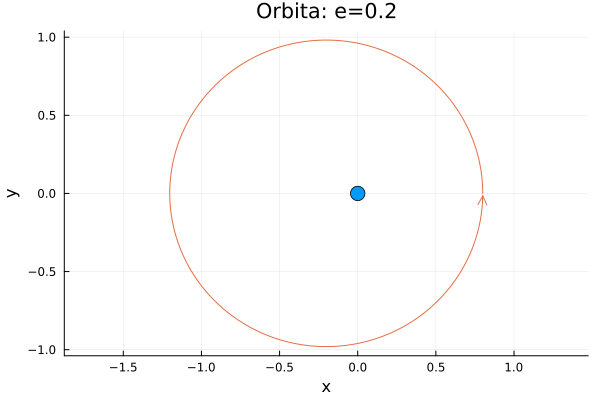

In [11]:
e = 0.2
t0 = 0.0
tf = 2.0 * pi
p = [0.]

tspan = (t0,tf)
u0    = [1-e, 0.0 , 0.0, sqrt( (1+e)/(1-e) ) ]
prob  = ProblemaEDO(f_2body,u0,tspan, p)

n   = 200 # -> h = pi/100
sol = EulerMejorado(prob,n)

tt = sol.t
xx = [u[1] for u in sol.u]
yy = [u[2] for u in sol.u]

plot([0.],[0.], marker=8, title="Orbita: e=$e", label="", aspect_ratio=1)
plot!(xx,yy, arrow=true, xlabel="x", ylabel="y", label="")

Se sabe que la solución exacta es periódica, con periodo $T=2 \pi$, de modo que el segundo cuerpo tiene las mismas posiciones y velocidades en $t=0$ y $t=T$. Por tanto, el error en el tiempo final $t_n=T$ se puede calcular de forma exacta.

\begin{align*}
\text{error}=\|u_{0}-u_{n}\|
\end{align*}

#### 1.3 - Determinar el error en el tiempo final $t_n=T$ para diferentes aproximaciones obtenidas con el método Euler Mejorado:  concretamente con las aproximaciones obtenidas aplicando n =[250, 500, 1000, 1500, 3000, 6000, 12000] pasos.


In [39]:
steps = [250, 500, 1000, 1500, 3000, 6000, 12000]
n     = 200 # -> h = pi/100

function calcularErrores(steps, verbose = false)
    errores_e  = []
    errores_em = []

    for n in steps
        sol_e    = Euler(prob,n)
        sol_em   = EulerMejorado(prob,n)
        error_e  = norm( sol_e.u[1]  - sol_e.u[end]  )
        error_em = norm( sol_em.u[1] - sol_em.u[end] )

        # Añadir el error a los arrays
        push!(errores_e, error_e)
        push!(errores_em, error_em)
        
        # Imprimir en pantalla
        if verbose
            println("pasos=", n)
            println("[EULER]          error = ", Float32(error_e))
            println("[EULER MEJORADO] error = ", Float32(error_em))
            println()
        end
    end
    return errores_e, errores_em
end

errores_e, errores_em   = calcularErrores(steps, true);

pasos=250
[EULER]          error = 2.12811
[EULER MEJORADO] error = 0.016586185

pasos=500
[EULER]          error = 1.3467227
[EULER MEJORADO] error = 0.0040496094

pasos=1000
[EULER]          error = 0.7591494
[EULER MEJORADO] error = 0.000999967

pasos=1500
[EULER]          error = 0.52485335
[EULER MEJORADO] error = 0.00044256853

pasos=3000
[EULER]          error = 0.2712349
[EULER MEJORADO] error = 0.00011017457

pasos=6000
[EULER]          error = 0.13765757
[EULER MEJORADO] error = 2.7484995e-5

pasos=12000
[EULER]          error = 0.069313735
[EULER MEJORADO] error = 6.8639047e-6



>**Comprobación**
>
> Se espera obtener los siguientes resultados:
> - pasos=250, error=0.016586184486239008
> - pasos=500, error=0.004049609410404857
> - pasos=1000, error=0.0009999669978226797
> - pasos=1500, error=0.00044256853545486665
> - pasos=3000, error=0.00011017457654403129
> - pasos=6000, error=2.7484994607311577e-5
> - pasos=12000, error=6.8639048281963945e-6

#### 1.4 - Según los resultados obtenidos sobre el error cometido por el método de Euler mejorado en $t=T$, ¿Cómo disminuye dicho error al dividir la longitud de paso $h$ por dos?

In [47]:
function imprimirFactorReduccionError(i, j, steps, errores)
    println("Factor de reduccion del error al dividir h / 2 [pasos (", steps[i],", ", steps[j], ")]: ", errores[i] / errores[j])
end

imprimirFactorReduccionError(1, 2, steps, errores_em)
imprimirFactorReduccionError(2, 3, steps, errores_em)
imprimirFactorReduccionError(4, 5, steps, errores_em)

Factor de reduccion del error al dividir h / 2 [pasos (250, 500)]: 4.0957491958664765
Factor de reduccion del error al dividir h / 2 [pasos (500, 1000)]: 4.04974306074345
Factor de reduccion del error al dividir h / 2 [pasos (1500, 3000)]: 4.01697514378913


> **Respuesta:** Al duplicar el número de pasos, la longitud de paso se divide por 2 y el error se reduce en un factor de 1/4

#### 1.5 - Repetir el ejercicio 1.3 pero esta vez aplicando el método de Euler en lugar del método de Euler mejorado

In [48]:
imprimirFactorReduccionError(1, 2, steps, errores_e)
imprimirFactorReduccionError(2, 3, steps, errores_e)
imprimirFactorReduccionError(4, 5, steps, errores_e)

Factor de reduccion del error al dividir h / 2 [pasos (250, 500)]: 1.5802138986765277
Factor de reduccion del error al dividir h / 2 [pasos (500, 1000)]: 1.7739890422401936
Factor de reduccion del error al dividir h / 2 [pasos (1500, 3000)]: 1.9350510416215967


#### 1.6 - Según los resultados obtenidos sobre el error cometido por el método de Euler en $t=T$, ¿Cómo disminuye dicho error al dividir la longitud de paso $h$ por dos?

> **Respuesta:** En este caso, el error también se reduce pero en menor medida que con el método de Euler mejorado. En este caso, el factor de reducción del error es de al rededor de 2 al dividir a la mitar la longitud de paso.

<a href="#top">Volver al inicio</a>

## 2-Satélite artificial orbitando alrededor de la tierra

### Modelo simplificado

Consideraremos la evolución de un satélite artificial moviéndose bajo el influjo gravitacional de la tierra. En el modelo matemático que consideramos seguídamente (propuesto en el siglo XVII por Isaac Newton), se supone para simplificar que la tierra es una esfera con campo gravitacional uniforme (la densidad de masa es constante o depende sólamente de la distancia al centro de la tierra). Las unidades utilizadas son kilómetros para la distancia, y segundos para el tiempo.

Según dicho modelo, las coordenadas (respecto del centro de la tierra) $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales de segundo orden:

\begin{align*}
\frac{d^2 x}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} x,\\ 
\frac{d^2 y}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} y,\\ 
\frac{d^2 z}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} z,
\end{align*}
    
donde  $\mu$ es la constante gravitacional del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8\, Km^3/s^2.
\end{equation*}

Dicho sistema de EDOs de segundo orden se puede reescribir como un sistema de EDOs de primer orden añadiendo las variables de estado $(v_x,v_y,v_z)$ correspondientes a las tres componentes de la velocidad del satélite:

\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    x \\ y \\ z \\v_x \\ v_y\\ v_z
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_x\\
 v_y\\
 v_z\\
 \displaystyle - \frac{\mu \, x}{(\sqrt{x^2+y^2+z^2})^3} ,\\ 
 \displaystyle - \frac{\mu \, y}{(\sqrt{x^2+y^2+z^2})^3},\\ 
\displaystyle -\frac{\mu \, z}{(\sqrt{x^2+y^2+z^2})^3},
  \end{matrix}
\right).
    \end{align*}


A lo largo del presente ejercicio, consideraremos las siguientes condiciones iniciales:

\begin{equation*}
  \begin{split}
 x(0)&=4.21491336e4 \, Km ,\  \qquad y(0)=0 ,\  \qquad z(0)=0, \\ 
 v_x(0)&=0 , \quad v_y(0)=3.075823259987749 \, Km/s, \quad v_z(0)=0.0010736649055318406\,  Km/s.
  \end{split}
\end{equation*}

En el modelo simplificado que estamos considerando, la órbita correspondiente a dichas condiciones iniciales es periódica con periodo $T=86169.546163670\, s$. Dicho periodo es aproximadamente igual al periodo de rotación de la tierra (23 horas, 56 minutos, y unos 9 segundos, es decir, un día sidéreo, ligéramente menor que la duración del día solar).


De hecho, dichas condiciones iniciales se corresponden a una _órbita
geoestacionaria_, es decir, la órbita de un satélite que se mantiene alineada con la recta que una el centro de la tierra con un punto concreto del ecuador, de tal forma que el satélite se mantiene estacionario con respecto a un observador fijado en dicho sitio del ecuador.  


#### 2.1 - Aplicar el método Euler Mejorado para calcular las coordenadas $(x_k,y_k,z_k)$ del satélite en en el intervalo temporal $[0,T]$, en concreto, en los tiempos $t_k=k\, T/1000$, para $k=0,1,\ldots,1000$ ($T=86169.546163670\, s$).  Utilizar $h=T/16000$ como longitud de paso del método Euler Mejorado. Obtener una figura con la trayectoria en 3D del satélite alrededor de la tierra.

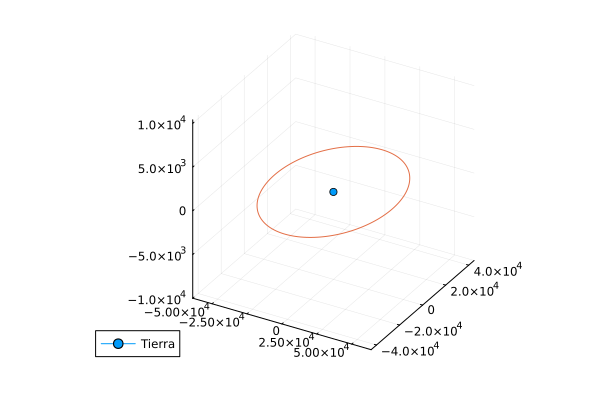

In [60]:
function fsat(t,u,p)
    x  = u[1]
    y  = u[2]
    z  = u[3]
    vx = u[4]
    vy = u[5]
    vz = u[6]
    mu = p[1]
    
    aux = x*x + y*y + z*z
    aux = sqrt( aux )
    aux = aux * aux * aux
    aux = 1 / aux
    
    dx  = vx
    dy  = vy
    dz  = vz
    dvx = - mu * x * aux
    dvy = - mu * y * aux
    dvz = - mu * z * aux
    return [ dx, dy, dz, dvx, dvy, dvz ]
end


mu = 398600.8 # μ
u0 = [4.21491336e4, 0.0, 0.0, 0.0, 3.075823259987749, 0.0010736649055318406] 

t0 = 0.
T = 86169.546163670

p = [ mu ]
tspan = (t0,T)
prob  = ProblemaEDO(fsat, u0, tspan, p)

n  = 1000
m  = 16
sol = EulerMejorado(prob,n,m)

tt = sol.t
xx = [ u[1] for u in sol.u ] 
yy = [ u[2] for u in sol.u ] 
zz = [ u[3] for u in sol.u ] 

plot([0.],[0.],[0.],marker=4,label="Tierra")
plot!(xx,yy,zz, aspect_ratio=1., zlimit=(-1.0e4,1.04e4), label="")

#### 2.2 - Se sabe que la solución exacta es periódica, con periodo $T$, de modo que tiene las mismas posiciones y velocidades en $t=0$ y  $t=T$, $t=2T$, $t=3T$ etc.  Calcular el error cometido  en los tiempos $t=T$, $t=2T$,  y $t=3T$ al aplicar el método de Euler mejorado con longitud de paso $h=T/16000$.

In [75]:
tspan = (0.0, 3*T)
n = 3000
m = 16
prob  = ProblemaEDO(fsat, u0, tspan, p)
sol = EulerMejorado(prob,n,m)

error_0 = norm( sol.u[1] - sol.u[1])
error_T = norm( sol.u[1] - sol.u[1001]) 
error_2T = norm( sol.u[1] - sol.u[2001])
error_3T = norm( sol.u[1] - sol.u[3001])

println("Error t=0: ", error_0 )
println("Error t=T: ", error_T)
println("Error t=2T: ", error_2T, " Factor de aumento de error: ",  error_2T / error_T)
println("Error t=3T: ", error_3T, " Factor de aumento de error: ",  error_3T / error_2T)

Error t=0: 0.0
Error t=T: 0.05453907326426707
Error t=2T: 0.10915377852226592 Factor de aumento de error: 2.0013867487877053
Error t=3T: 0.16384412301170345 Factor de aumento de error: 1.501039407245819


#### 2.3 - A la vista de dichos resultados sobre los errores cometidos en los tiempos $t=T$, $t=2T$,  y $t=3T$, ¿qué error esperas que se cometería para $t=4T$? 

>**Respuesta:**
> Se podría esperar un error cercano al doble del error en 3T

#### 2.4 - Repetir el ejercicio 2.3, pero esta vez para el método de Euler aplicado con longitud de paso $h=T/32000$.

In [86]:
tspan = (0.0, 3*T)
n = 3000
m = 32
prob  = ProblemaEDO(fsat, u0, tspan, p)
sol = Euler(prob,n,m)


error_0 = norm( sol.u[1] - sol.u[1])
error_T = norm( sol.u[1] - sol.u[1000]) 
error_2T = norm( sol.u[1] - sol.u[2001])
error_3T = norm( sol.u[1] - sol.u[3001])

println("Error t=0: ", error_0 )
println("Error t=T: ", error_T)
println("Error t=2T: ", error_2T, " Factor de aumento de error: ",  error_2T / error_T)
println("Error t=3T: ", error_3T, " Factor de aumento de error: ",  error_3T / error_2T)

Error t=0: 0.0
Error t=T: 761.0627270234767
Error t=2T: 1963.6911467042007 Factor de aumento de error: 2.5801961874866937
Error t=3T: 4391.840271400679 Factor de aumento de error: 2.2365229271272162


#### 2.5 - En base a los resultados de los ejercicios 2.2 y 2.4, ¿piensas que está justificado el nombre del método de Euler mejorado?

>**Respuesta:**
> Con el método de Euler tradicional, el error aumenta el doble que con el método de Euler mejorado

<a href="#top">Volver al inicio</a>

### Modelo más realista


En el apartado anterior, hemos supuesto que la tierra es esférica, cuando en realidad presenta un ligero achatamiendo en ambos polos.  En el modelo matemático que consideramos a continuación, se obtiene una descripción más realista del movimiento del satélite artificial teniendo en cuenta dicho achatamiento. (Sin embargo, no se tiene en cuenta otros efectos de índole menor, como  el efecto gravitacional de la luna, el sol, y otros cuerpos celestes, ni el efecto de irregularidades menores del campo gravitacional de la tierra).

Según este modelo matemático, las coordenadas respecto del centro de la tierra $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales de segundo orden:

\begin{align*}
\frac{d^2 x}{dt^2} &= -\mu \frac{x}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right),\\ 
\frac{d^2 y}{dt^2} &= -\mu \frac{y}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right),\\ 
\frac{d^2 z}{dt^2} &= -\mu \frac{z}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, G \right),
\end{align*}

donde 
\begin{equation*}
r=\sqrt{x^2+y^2+z^2}, \quad
  F = \frac{3}{2} -  \frac{15z^2}{2r^2},  \quad G = \frac{9}{2} - \frac{15z^2}{2r^2},
\end{equation*}

y $\mu$, $R$, y $\epsilon$, respectivamente, son la constante gravitacional, el radio, y el coeficiente de achatamiento del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8 Km^3/s^2, \quad R = 6\, 378.135Km,  \quad               
    \epsilon = 0.0010826157.
\end{equation*}

Como en el modelo simplificado considerado en el apartado anterior, este sistema de EDOs de segundo orden se puede reescribir como un sistema de EDOs de primer orden añadiendo las variables de estado $(v_x,v_y,v_z)$ correspondientes a las tres componentes de la velocidad del satélite.

#### 2.6 - ¿Cuales son las variables de estado? ¿Cuales son los parámetros constantes del problema? ¿Qué variables no son ni variables de estado ni parámetros constantes del problema (sino variables auxiliares intermedias utilizadas para definir de forma conveniente las distinas componentes de la aceleración del satélite)?

>**Respuesta**
>
>- Las variables de estado son: la posición dada por las variables x, y y z
>- Los parámetros constantes del problema son: la constante gravitacional, el radio y el coeficiente de achatamiento del planeta
>- Las variables auxiliares intermedias son: r, F y G


A lo largo del presente ejercicio, consideraremos las mismas condiciones iniciales que en el apartado anterior. Queremos comprobar si, en el caso del modelo más realista, la trayectoria correspondiente sigue siendo periódica, con periodo $T$.


#### 2.7 - Aplicar el método Euler Mejorado, utilizando $h=T/16000$ como longitud de paso, para calcular las posiciones y velocidades del satélite en los tiempos $t_k=k\, T/1000$, para $k=0,1,\ldots,1000$. Calcular la distancia entre las posiciones del satélite en $t=0$ y $t=T$.

In [90]:
function fsat2(t,u,p)
    μ = p[1]
    R = p[2]
    ϵ = p[3]
    x = u[1]
    y = u[2]
    z = u[3]
    vx = u[4]
    vy = u[5]
    vz = u[6]
    r2 = x*x + y*y + z*z
    r = sqrt(r2)
    aux1 = 1 / r^3
    F = 1.5 - 7.5*(z/r)^2
    G =  3 + F
    aux2 = ϵ*(R/r)^2
    aux3 = aux1*(1+aux2*F)
    aux4 = aux1*(1+aux2*G)
    return [vx, vy, vz, aux3*x, aux3*y, aux4*z]
		
end

μ = 398600.8


R = 6378.135
ϵ = 0.0010826157
p = [μ, R, ϵ]
u0 = [4.21491336e4,0.0,0.0, 0.0, 3.075823259987749,0.0010736649055318406 ] 

t0=0.
T = 86169.546163670

tspan=(t0,T)
prob=ProblemaEDO(fsat2,u0,tspan,p)

n = 1000
m = 16
sol = EulerMejorado(prob,n,m)

tt = sol.t
xx = [ u[1] for u in sol.u ] 
yy = [ u[2] for u in sol.u ] 
zz = [ u[3] for u in sol.u ] 

dist = norm( [ xx[end] - xx[1], yy[end] - yy[1], zz[end] - zz[1] ] ) 

265042.70693630853

>**Resultado esperado:**
>
> dist = 19.64576522884421

#### 2.8 - Comprobaréis que dicha distancia no es cero. ¿Esto será debido al error inherente al método Euler Mejorado utilizado, o a que realmente la trayectoria del satélite en el nuevo modelo ya no es periódica con periodo $T$?

>**Respuesta**
>
>

#### 2.9 - Para tratar de responder con más seguridad a la pregunta del apartado 2.8,  repetir el ejercicio 2.7 con $h=T/32000$, y comparar el nuevo valor de la distancia obtenida con el del apartado 2.7. 

In [ ]:
??

#### 2.10 Basandote en dicha comparación,  responder de forma razonada si la trayectoria del satélite en el modelo más realista es periódica de periodo $T$ o no.

>**Respuesta**
>
>

<a href="#top">Volver al inicio</a>